In [1]:
%run '/home/christianl/Zhang-Lab/Zhang Lab Code/Boilerplate_datahandling/Remote boilerplate/Fig_config_utilities.py'

<class 'numpy.ndarray'> (3187, 16100)
<class 'numpy.ndarray'> (3187, 16100)
LOADING MODEL - EXACT TRAINING SCRIPT SEQUENCE

1. Loading checkpoint from: /home/christianl/Zhang-Lab/Zhang Lab Data/Saved models/RNN/uncentered_data_RNN/signaling_model.v1.pt

2. Loading network from: /home/christianl/Zhang-Lab/Zhang Lab Data/Full data files/network(full).tsv
   Network shape: (1153904, 3)
   Network columns: ['TF', 'Gene', 'Interaction']

3. Formatting network...

4. Using EXACT benchmark.py parameters
   projection_amplitude_in: 1.2
   projection_amplitude_out: 1.2
   bionet_params: {'target_steps': 150, 'max_steps': 10, 'exp_factor': 50, 'tolerance': 1e-20, 'leak': 0.01}

5. Initializing model with DataFrames...
   Input X_in shape: (3187, 1197)
   Input y_out shape: (3187, 16100)
  Filtered X_in: 1197 → 1197 features
  Filtered y_out: 16100 → 16100 features
   ✓ Model initialized (data automatically filtered)

6. Converting DataFrames to tensors...
   ✓ Tensors created

7. Applying traini

In [7]:
# Check what your y_test columns actually are:
print("y_test columns type:", type(y_test.columns))
print("First 5 column names:", y_test.columns[:5].tolist())

# Also check if y_test is actually a DataFrame or numpy array:
print("y_test type:", type(y_test))

y_test columns type: <class 'pandas.core.indexes.base.Index'>
First 5 column names: ['A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'AAAS']
y_test type: <class 'pandas.core.frame.DataFrame'>


In [10]:
import inspect
print(inspect.getsource(compute_metrics_per_gene))

def compute_metrics_per_gene(y_true_df, y_pred_array):
    """
    Compute per-gene metrics with gene names preserved.
    
    Parameters
    ----------
    y_true_df : pd.DataFrame
        True values with gene names as columns
    y_pred_array : np.ndarray
        Predictions (same shape as y_true_df.values)
    """
    n_genes = y_true_df.shape[1]
    results = []

    for i, gene_name in enumerate(y_true_df.columns):  # ← Use actual gene names!
        y_t = y_true_df.iloc[:, i].values
        y_p = y_pred_array[:, i]
    
        if np.var(y_t) > 1e-10:
            pearson_r, p_value = pearsonr(y_t, y_p)
            r2 = r2_score(y_t, y_p)
        
            results.append({
                'gene': gene_name,  # ← Biological ID preserved!
                'gene_idx': i,
                'r2': r2,
                'pearson_r': pearson_r,
                'p_value': p_value,
                # ...
            })

    return pd.DataFrame(results)



In [12]:
# Completely bypass the file and define the function directly in the notebook:
def compute_metrics_per_gene_test(y_true_df, y_pred_array):
    """Compute per-gene metrics."""
    n_genes = y_true_df.shape[1]
    results = []
    
    for i, gene_name in enumerate(y_true_df.columns):
        y_t = y_true_df.iloc[:, i].values
        y_p = y_pred_array[:, i]
        
        if np.var(y_t) > 1e-10:
            pearson_r, p_value = pearsonr(y_t, y_p)
            r2 = r2_score(y_t, y_p)
            
            results.append({
                'gene': gene_name,
                'gene_idx': i,
                'r2': r2,
                'pearson_r': pearson_r,
                'p_value': p_value
            })
    
    return pd.DataFrame(results)

# Now test it:
metrics_flat_per_gene_mlr = compute_metrics_per_gene_test(y_test, mlr_y_pred)
print(metrics_flat_per_gene_mlr.head())

      gene  gene_idx        r2  pearson_r  p_value
0      A2M         0  0.861767   0.929369      0.0
1    A2ML1         1  0.747973   0.866240      0.0
2  A3GALT2         2  0.373796   0.644981      0.0
3   A4GALT         3  0.769920   0.879001      0.0
4     AAAS         4  0.859807   0.928639      0.0


In [ ]:
# diagnostics of MLR r2 scores

# checking to ensure predictions and groundtruth are comparable (they do)
assert y_test.shape == mlr_y_pred.shape

# compare r2 values
# .score() r2 is the variance-weighted r2, which computes each gene's r2 individually (genes are treated differently) 
# as each gene predictions are still in 2D Numpy arrays not flattened
# mlr_loaded.score: 0.7986089431408789
print("mlr_loaded.score:", mlr_loaded.score(x_test, y_test))

# compute_metrics() is the flattened r2, where each gene's r2 is treated equally (flattened) before aggregating
# compute_metrics r2: 0.9323357932034118

# compute_metrics r2 > .score() r2 -> figured out that .score() when unspecified does uniform-average, different to compute_metrics r2 
# which calculates the variance-weighted r2, taking into account the individual variances of each gene.
# given the difference of 0.365 between the two, positive correlation between variance and R2 indicates that model performs better
# on genes with higher variance (more distinct expression patterns) than lower variance ones (ie. housekeeping, "silenced", etc.)

metrics_flat_mlr = compute_metrics(y_test.values, mlr_y_pred)
print("compute global R²:", metrics_flat_mlr['r2'])

# compute_metrics_per_gene() looks at the indiviudal r2 at per-gene resolution (using DFs to maintain biological relevance of each column) 

#compute_metrics_per_gene r2: 0        0.861767
#1        0.747973
#2        0.373796
#3        0.769920
#4        0.859807
#           ...   
#16095    0.736619
#16096    0.866326
#16097    0.924248
#16098    0.912513
#16099    0.900036
#Name: r2, Length: 16100, dtype: float64

metrics_flat_per_gene_mlr = compute_metrics_per_gene_test(y_test, mlr_y_pred)
print("compute_metrics_per_gene R²:", metrics_flat_per_gene_mlr['r2'])

y_test shape: (3187, 16100)
y_pred_mlr shape: (3187, 16100)
mlr_loaded.score: 0.7986089431408789
compute_metrics r2: 0.9323357932034118
compute_metrics_per_gene r2: 0        0.861767
1        0.747973
2        0.373796
3        0.769920
4        0.859807
           ...   
16095    0.736619
16096    0.866326
16097    0.924248
16098    0.912513
16099    0.900036
Name: r2, Length: 16100, dtype: float64


In [ ]:
# same diagnostics for XGBRF.v3 (trained on same x_train)
# checking to ensure predictions and groundtruth are comparable
assert y_test.shape == xgbrf_y_pred.shape

# computing XGBRF metrics (aggregate and per gene (per model is this case))
# compute global R²: 0.9136
metrics_flat_xgbrf = compute_metrics(y_test.values, xgbrf_y_pred)
print(f"compute global R²: {metrics_flat_xgbrf['r2']:.4f}")

#compute_metrics_per_gene R²: 0        0.798614
#1        0.732539
#2        0.390864
#3        0.717345
#4        0.819955
#           ...   
#16095    0.677608
#16096    0.801420
#16097    0.883455
#16098    0.861673
#16099    0.863954
#Name: r2, Length: 16100, dtype: float64

metrics_flat_per_gene_xgbrf = compute_metrics_per_gene_test(y_test, xgbrf_y_pred)
print("compute_metrics_per_gene R²:", metrics_flat_per_gene_xgbrf['r2'])


compute global R²: 0.9136


In [ ]:
# same diagnostics for RNN.v1 (used as a reference for data preprocessing of other models )
# checking to ensure predictions and groundtruth are comparable
assert y_test.shape == rnn_y_pred.shape

# computing RNN metrics (aggregate and per gene (per model is this case))
# compute global R²: 0.7366
metrics_flat_rnn = compute_metrics(y_test.values, rnn_y_pred)
print(f"compute global R²: {metrics_flat_rnn['r2']:.4f}")

#compute_metrics_per_gene R²: 0        0.249111
#1       -0.058234
#2       -0.235948
#3        0.382344
#4        0.671084
#           ...   
#16095    0.336766
#16096    0.509802
#16097    0.657901
#16098    0.514623
#16099    0.622254
#Name: r2, Length: 16100, dtype: float64

metrics_flat_per_gene_rnn = compute_metrics_per_gene_test(y_test, rnn_y_pred)
print("compute_metrics_per_gene R²:", metrics_flat_per_gene_rnn['r2'])

# lower R² than I would have expected - maybe the test-train splitting was different for model training? 21/01/26

compute global R²: 0.7366


In [ ]:
# observed vs. expected prediction scatterplots with Pearson's R
def figure_1_observed_vs_predicted(y_true, predictions_dict, 
                                  r2_method='variance_weighted',
                                  output_path='~/Zhang-Lab/Zhang Lab Data/Saved figures/'):
    """
    Generate observed vs. predicted scatterplot with Pearson correlation.
    
    Parameters
    ----------
    y_true : array-like, shape (n_samples, n_genes)
        True target gene expression values
    predictions_dict : dict
        Dictionary with keys as model names and values as predictions
        Example: {'RNN': pred_rnn, 'XGBRFRegressor': pred_xgb, 'Linear': pred_linear}
    r2_method : str, default='variance_weighted'
        Method for computing R² in multi-output setting:
        - 'variance_weighted': Weight genes by their variance (default sklearn behavior for flattened)
        - 'uniform_average': Simple mean of per-gene R² (default sklearn .score() behavior)
        - 'flattened': Explicitly compute on flattened data (same as variance_weighted)
    output_path : str
        Path to save figure
    """
    set_publication_style()
    fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_TRIPLE)
    model_names = list(predictions_dict.keys())
    
    for idx, model_name in enumerate(model_names):
        ax = axes[idx]
        y_pred = predictions_dict[model_name]
        
        # Flatten arrays for scatter plot
        y_true_flat = np.asarray(y_true).ravel()
        y_pred_flat = np.asarray(y_pred).ravel()
        
        # Compute metrics based on specified method
        if r2_method == 'variance_weighted' or r2_method == 'flattened':
            # Compute R² on flattened data (equivalent to variance-weighted)
            r2 = r2_score(y_true_flat, y_pred_flat)
            r2_label = "R² (variance-weighted)"
        elif r2_method == 'uniform_average':
            # Compute mean of per-gene R²
            r2 = r2_score(y_true, y_pred, multioutput='uniform_average')
            r2_label = "R² (uniform average)"
        else:
            raise ValueError(f"Unknown r2_method: {r2_method}")
        
        # Pearson correlation (always on flattened data for scatter plot)
        pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)
        
        # Scatter plot
        ax.scatter(y_true_flat, y_pred_flat, alpha=0.5, s=30, 
                   color=MODEL_COLORS.get(model_name, '#1f77b4'),
                   edgecolors='none')
        
        # Perfect prediction diagonal line
        min_val = min(y_true_flat.min(), y_pred_flat.min())
        max_val = max(y_true_flat.max(), y_pred_flat.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', 
                lw=2, alpha=0.5, label='Perfect prediction')
        
        # Fit regression line
        z = np.polyfit(y_true_flat, y_pred_flat, 1)
        p = np.poly1d(z)
        x_line = np.linspace(y_true_flat.min(), y_true_flat.max(), 100)
        y_line = p(x_line)
        ax.plot(x_line, y_line, color=MODEL_COLORS.get(model_name, '#1f77b4'),
                lw=2.5, alpha=0.8, label='Linear fit')
        
        # Labels and formatting
        ax.set_xlabel('Observed Expression', fontsize=12, fontweight='bold')
        ax.set_ylabel('Predicted Expression', fontsize=12, fontweight='bold')
        ax.set_title(model_name, fontsize=13, fontweight='bold')
        
        # Add metrics text box
        textstr = f"Pearson's R = {pearson_r:.4f}\n{r2_label} = {r2:.4f}\np < 0.001" \
            if p_value < 0.001 else \
            f"Pearson's R = {pearson_r:.4f}\n{r2_label} = {r2:.4f}\np = {p_value:.3f}"
        
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
    print(f"Figure 1 saved to {output_path}")
    plt.show()
    
    # Return metrics for reference (including both R² methods)
    metrics_summary = {}
    for model_name in model_names:
        y_pred = predictions_dict[model_name]
        y_true_flat = np.asarray(y_true).ravel()
        y_pred_flat = np.asarray(y_pred).ravel()
        
        pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)
        r2_variance_weighted = r2_score(y_true_flat, y_pred_flat)
        r2_uniform = r2_score(y_true, y_pred, multioutput='uniform_average')
        rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        
        metrics_summary[model_name] = {
            'pearson_r': pearson_r,
            'p_value': p_value,
            'r2_variance_weighted': r2_variance_weighted,
            'r2_uniform_average': r2_uniform,
            'rmse': rmse,
            'mae': mae
        }
    
    return metrics_summary

AttributeError: 'numpy.ndarray' object has no attribute 'values'

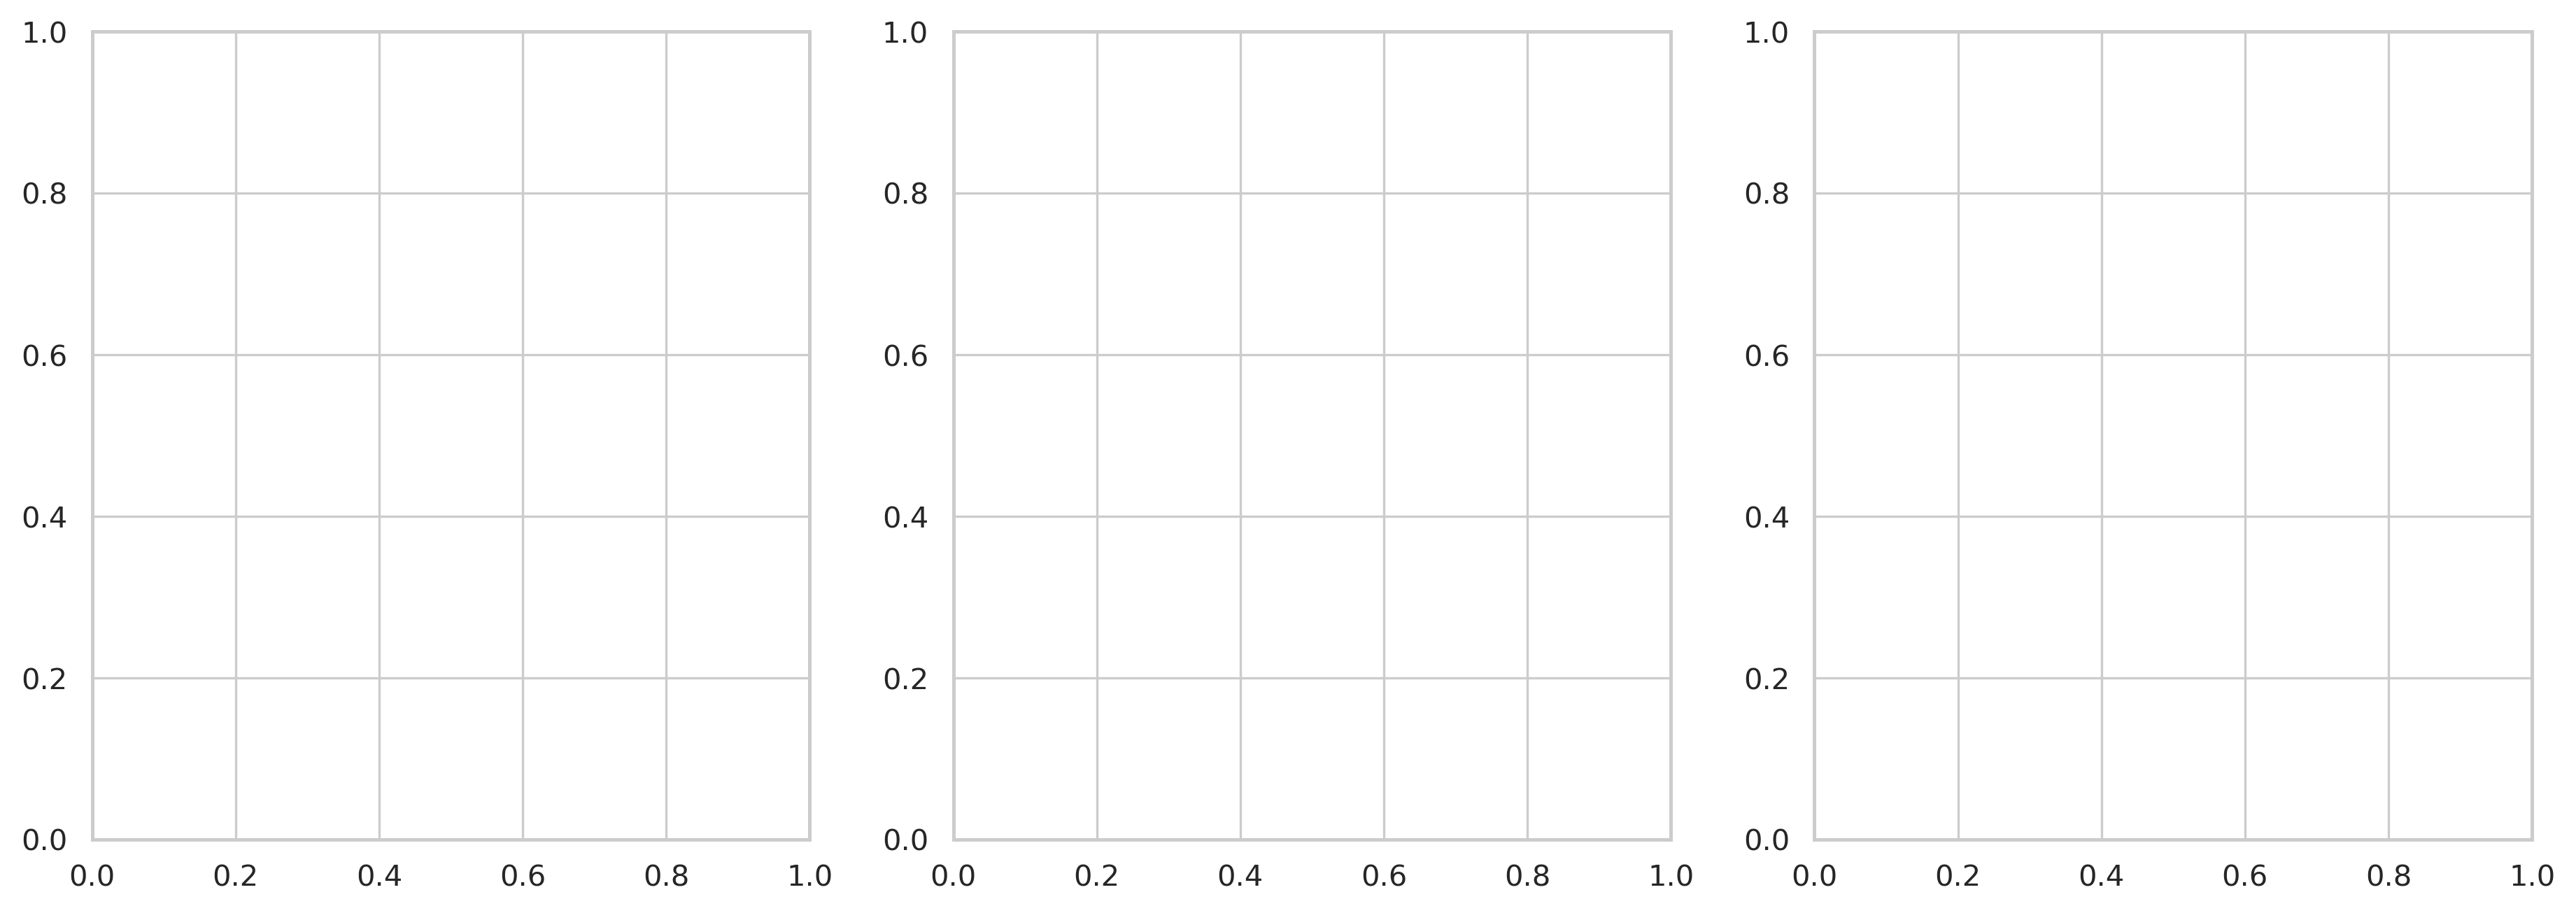

In [16]:
# XGBRF was trained on x_test not x_test_centered so needs to be retrained for real interpretable results
# Retrained XGBRF on centered data, redone and resaved as "fig1_centered"
figure_1_observed_vs_predicted(y_test,predictions,r2_method='variance_weighted', output_path = '/home/christianl/Zhang-Lab/Zhang Lab Data/Saved figures/Production_model_figures/figure1_(PRODUCTION)).png')